### Character Matching
This notebook matches the characters from the screenplays to their respective imdb cast. This notebook involves cleaning the data, manual inspection along with the actual matching.

In [ ]:
import pandas as pd
import os
import json
import re
import csv
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

`clean_validated.csv` is the file generated after validating imdb ids collected by the tool.

In [ ]:
METADATA_DIR = '../../data/8_screenplays/'

In [ ]:
df_meta = pd.read_csv(f'{METADATA_DIR}/1_validation/clean_validated.csv', dtype={'imdb_id': str, 'id_merged': str})

In [ ]:
df_meta = df_meta.drop(['match', 'alt_id', 'notes'], axis=1)

In [ ]:
df_meta.head()

,imdb_id,title,script_url,filename,id_merged,char_fname
0,0417385,12 and Holding,https://imsdb.com/scripts/12-and-Holding.html,12-and-Holding,0417385,12-and-Holding_charinfo.txt
1,2024544,12 Years a Slave,https://imsdb.com/scripts/12-Years-a-Slave.html,12-Years-a-Slave,2024544,12-Years-a-Slave_charinfo.txt
2,1542344,127 Hours,https://imsdb.com/scripts/127-Hours.html,127-Hours,1542344,127-Hours_charinfo.txt
3,0179626,15 Minutes,https://imsdb.com/scripts/15-Minutes.html,15-Minutes,0179626,15-Minutes_charinfo.txt
4,0974661,17 Again,https://imsdb.com/scripts/17-Again.html,17-Again,0974661,17-Again_charinfo.txt


In [ ]:
df_meta.shape

(1493, 6)

`validated_movies.csv` is the file with the IMDb metadata of all the validated movies in our screenplay dataset.

In [ ]:
df_movies = pd.read_csv(f'{METADATA_DIR}/2_metadata/validated_movies.csv', dtype={'imdbID': str })

In [ ]:
movie_ids = df_movies[['imdbID', 'localized title']]

In [ ]:
df_merged = movie_ids.merge(df_meta[['id_merged', 'filename', 'title', 'char_fname']], how='left', left_on='imdbID', right_on='id_merged').drop(['id_merged'], axis=1)

In [ ]:
df_merged.head()

,imdbID,localized title,filename,title,char_fname
0,0417385,12 and Holding,12-and-Holding,12 and Holding,12-and-Holding_charinfo.txt
1,2024544,12 Years a Slave,12-Years-a-Slave,12 Years a Slave,12-Years-a-Slave_charinfo.txt
2,1542344,127 Hours,127-Hours,127 Hours,127-Hours_charinfo.txt
3,0179626,15 Minutes,15-Minutes,15 Minutes,15-Minutes_charinfo.txt
4,0974661,17 Again,17-Again,17 Again,17-Again_charinfo.txt


In [ ]:
df_merged.shape

(1468, 5)

The dialogue, characters, and tagged files are stored in files with the following naming formats as in this example.

- Hellboy-2-The-Golden-Army_dialogue.txt
- Hellboy-2-The-Golden-Army_charinfo.txt
- Hellboy-2-The-Golden-Army_parsed.txt

First, let's check how many of these files are present in the charinfo directory. Some files may have not been parsed because of parsing issues, poor screenplay quality, etc.

In [ ]:
BASE_DIR = f'{METADATA_DIR}/parsed_screenplays/parsed'

In [ ]:
movie_chars = os.listdir(os.path.join(BASE_DIR, 'charinfo'))

In [ ]:
movie_chars[:5]

['Nine_charinfo.txt',
 'Next-Three-Days-The_charinfo.txt',
 'Ni-vu-ni-connu_charinfo.txt',
 'Observe-and-Report_charinfo.txt',
 'Oblivion_charinfo.txt']

In [ ]:
len(movie_chars)

1596

In [ ]:
missing_charinfo = []

for movie in df_merged['char_fname']:
  if movie not in movie_chars:
    missing_charinfo.append(movie)

In [ ]:
len(missing_charinfo)

47

In [ ]:
with open('./parse_failure_movies.csv', 'w') as f:
  writer = csv.writer(f)

  for m in missing_charinfo:
    writer.writerow([m])

We'll only select movies that have associated parsed files for them.

In [ ]:
df_clean = df_merged[~df_merged['char_fname'].isin(missing_charinfo)]

In [ ]:
df_clean.shape

(1421, 5)

Now, we have 1467 - 47 = 1420 remaining movies.

### Now, we'll read all the character info.

In [ ]:
!pip install fuzzywuzzy python-Levenshtein thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.2 MB/s eta 0:00:00


In [ ]:
from thefuzz import fuzz

The following is an example of how string matching works. This also highlights the issue of how characters can be named differently in the screenplay making matching difficult.

In [ ]:
fuzz.WRatio("Colonel Coetzee", "THE COLONEL")

74

In [ ]:
df_clean.head()

,imdbID,localized title,filename,title,char_fname
0,0417385,12 and Holding,12-and-Holding,12 and Holding,12-and-Holding_charinfo.txt
1,2024544,12 Years a Slave,12-Years-a-Slave,12 Years a Slave,12-Years-a-Slave_charinfo.txt
2,1542344,127 Hours,127-Hours,127 Hours,127-Hours_charinfo.txt
3,0179626,15 Minutes,15-Minutes,15 Minutes,15-Minutes_charinfo.txt
4,0974661,17 Again,17-Again,17 Again,17-Again_charinfo.txt


In [ ]:
rows = []
empty_files = []

for index, row in df_clean.iterrows():
  item = row['char_fname']
  imdb = row['imdbID']

  file_path = os.path.join(BASE_DIR, 'charinfo', item)

  with open(file_path, 'r') as f:
    data = f.read()
    if data == "":
      empty_files.append((imdb, item))
      continue

    for line in data.split('\n'):
      if line == "": continue
      item = {}

      # characters are in the format (NAME:3)
      index = line.rfind(":")

      item['imdb'] = imdb
      item['char'] = line[:index].strip()
      item['utterances'] = line[index+1:].strip()

      rows.append(item)

We lost 3 more files because they are empty, so the resulting number is 1417.

In [ ]:
empty_files

[('0100260', 'Nightbreed_charinfo.txt'),
 ('0376874', 'Sexual-Life_charinfo.txt'),
 ('0094012', 'Space-Ball_charinfo.txt')]

In [ ]:
df_temp = pd.DataFrame(rows)
df_temp['utterances'] = pd.to_numeric(df_temp['utterances'], errors='coerce')

In [ ]:
df_temp.utterances.value_counts()

1      37203
2       9075
3       5147
4       3474
5       2621
       ...  
423        1
401        1
526        1
509        1
295        1
Name: utterances, Length: 488, dtype: int64

In [ ]:
df_temp.head()

,imdb,char,utterances
0,0417385,ASHLEY,36
1,0417385,COACH,9
2,0417385,DEBBIE,2
3,0417385,DOCTOR,6
4,0417385,GABE,6


In [ ]:
len(df_temp['imdb'].unique())

1417

`all_characters.csv` is a file with all the characters in all the movies of our dataset

In [ ]:
if not os.path.exists(f'{METADATA_DIR}/3_character_matching'): os.mkdir(f'{METADATA_DIR}/3_character_matching')

df_temp.to_csv(f'{METADATA_DIR}/3_character_matching/all_characters.csv', index=False, escapechar='\\')

Mostly, when there is only 1 utterance by a character, it is likely that the character is erroneous and a result of parsing error. Certain sentences or phrases are tagged as characters which is an error.

#### Now, we look at total dialogues in movies.

In [ ]:
total_utts = df_temp.groupby('imdb').sum(numeric_only=True).reset_index().rename(columns={"utterances": "total_utt"})
# df_temp_utts = df_temp.merge(total_utts, on='imdb', how='left')

Text(0.5, 1.0, 'Histogram of total dialogues in all movies')

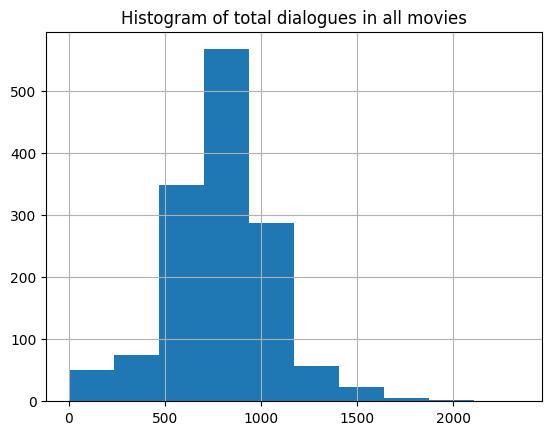

In [ ]:
total_utts['total_utt'].hist()
plt.title("Histogram of total dialogues in all movies")

Need to also remove scripts with only few total dialogues.

In [ ]:
total_utts.to_csv(f'{METADATA_DIR}/3_character_matching/total_utterances.csv', index=False)

In [ ]:
total_utts.head()

,imdb,total_utt
0,0017350,8
1,0018037,18
2,0021214,144
3,0022054,1088
4,0022958,1131


In [ ]:
df_utt = df_clean.merge(total_utts, how='left', left_on='imdbID', right_on='imdb').drop(['imdbID'], axis=1)
df_utt = df_utt[~df_utt['imdb'].isnull()]

In [ ]:
df_utt.head()

,localized title,filename,title,char_fname,imdb,total_utt
0,12 and Holding,12-and-Holding,12 and Holding,12-and-Holding_charinfo.txt,0417385,730.0
1,12 Years a Slave,12-Years-a-Slave,12 Years a Slave,12-Years-a-Slave_charinfo.txt,2024544,786.0
2,127 Hours,127-Hours,127 Hours,127-Hours_charinfo.txt,1542344,256.0
3,15 Minutes,15-Minutes,15 Minutes,15-Minutes_charinfo.txt,0179626,983.0
4,17 Again,17-Again,17 Again,17-Again_charinfo.txt,0974661,818.0


In [ ]:
df_utt[df_utt['imdb'].isnull()]

,localized title,filename,title,char_fname,imdb,total_utt


In [ ]:
df_utt.shape

(1417, 6)

Now, we can inspect what movies are associated with the utterances for easier lookup.

In [ ]:
df_utt[df_utt['total_utt'] == 0]

,localized title,filename,title,char_fname,imdb,total_utt
917,Legionnaire,Legionnaire,Legionnaire,Legionnaire_charinfo.txt,0126388,0.0


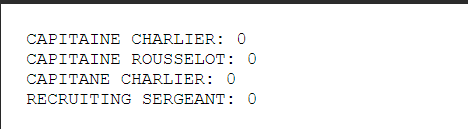

Text(0.5, 1.0, 'Histogram of total dialogues for movies with < 500 dialogues')

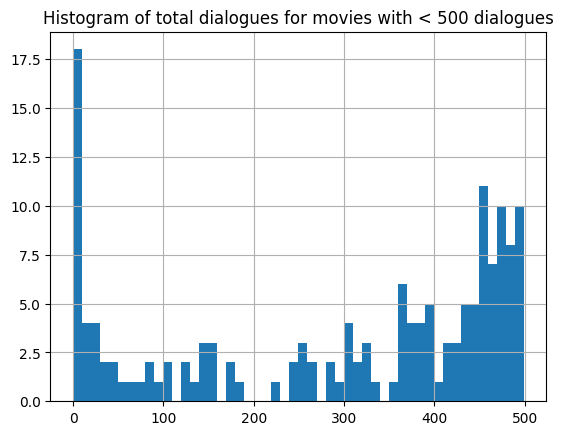

In [ ]:
df_utt[df_utt['total_utt'] < 500]['total_utt'].hist(bins=50)
plt.title("Histogram of total dialogues for movies with < 500 dialogues")

We remove all movies that don't have at least 50 dialogues in them.

In [ ]:
df_utt_clean = df_utt[df_utt['total_utt'] > 50]

In [ ]:
df_utt_clean.shape

(1387, 6)

When we remove all movies with <=50 total dialogues, we are left with 1387 movies.

### Clean characters

Now, we move towards cleaning the characters.

In [ ]:
df_temp

,imdb,char,utterances
0,0417385,ASHLEY,36
1,0417385,COACH,9
2,0417385,DEBBIE,2
3,0417385,DOCTOR,6
4,0417385,GABE,6
...,...,...,...
79781,1340800,TUFTY THESINGER,2
79782,1340800,WATCHED.,1
79783,1340800,WOMAN’S VOICE,1
79784,1340800,“KARLA”.,1


Now, we clean by evaluating number of words in char.

In [ ]:
df_temp['char_len'] = df_temp['char'].str.split().str.len()

In [ ]:
df_temp_sub = df_temp[df_temp['char_len'] < 7]

In [ ]:
df_temp.shape, df_temp_sub.shape

((79786, 4), (79353, 4))

In [ ]:
df_sub_clean = df_temp_sub[df_temp_sub['utterances'] > 1]    # we'll also select chars with more than one utterance

In [ ]:
df_temp_sub.shape, df_sub_clean.shape

((79353, 4), (42342, 4))

In [ ]:
len(df_temp_sub['imdb'].unique()), len(df_sub_clean['imdb'].unique())

(1416, 1400)

Now, we'll also add total utterances for each movie in df_sub_clean.

In [ ]:
df_sub_clean

,imdb,char,utterances,char_len
0,0417385,ASHLEY,36,1
1,0417385,COACH,9,1
2,0417385,DEBBIE,2,1
3,0417385,DOCTOR,6,1
4,0417385,GABE,6,1
...,...,...,...,...
79771,1340800,SAL,3,1
79773,1340800,SMILEY,158,1
79774,1340800,SMILEY’S P.O.V.,3,2
79780,1340800,TOBY ESTERHASE,20,2


After merging we'll be left with 1387. This merging could be a replacement for all the work we have done earlier with counting char length and choosing chars with >1 utterance. (Removing movies with <50 utterances might be enough to remove many of the erroneous characters as well)

In [ ]:
df_sub_clean = df_sub_clean.merge(total_utts, on='imdb', how='left')
df_sub_total = df_sub_clean[df_sub_clean['imdb'].isin(df_utt_clean['imdb'].values)]

In [ ]:
df_sub_total[df_sub_total['total_utt'].isnull()]

,imdb,char,utterances,char_len,total_utt


In [ ]:
len(df_sub_total['imdb'].unique())

1387

In [ ]:
df_sub_total.head()

,imdb,char,utterances,char_len,total_utt
0,0417385,ASHLEY,36,1,730
1,0417385,COACH,9,1,730
2,0417385,DEBBIE,2,1,730
3,0417385,DOCTOR,6,1,730
4,0417385,GABE,6,1,730


Since we removed characters with just 1 or 0 utterances, some scripts were also removed because some scripts had only characters with 0 utterances because of parsing errors.

### Now, we'll get all cast and characters for each movie id and compare the character names with the script

In [ ]:
df_cast = pd.read_csv(f'{METADATA_DIR}/2_metadata/all_cast.csv', dtype={'imdbID': str, 'personID': str})

In [ ]:
df_cast.head()

,imdbID,personID,person,characters
0,0417385,1331627,Conor Donovan,"Jacob,Rudy Carges"
1,0417385,1028466,Jesse Camacho,Leonard Fisher
2,0417385,1494624,Zoe Weizenbaum,Malee Chuang
3,0417385,0719637,Jeremy Renner,Gus Maitland
4,0417385,0001711,Annabella Sciorra,Carla Chuang


In [ ]:
len(df_cast['imdbID'].unique())

1466

Now, we run the algorithm to find the matches.

In [ ]:
imdbs = df_sub_total['imdb'].unique()
rows = []
no_chars = []

for id in imdbs:
  script_chars = df_sub_total[df_sub_total['imdb'] == id].sort_values(by='utterances', ascending=False)
  imdb_chars = df_cast[df_cast['imdbID'] == id]

  if len(imdb_chars) == 0:
    no_chars.append(id)
    rows.append([{'imdb': id}])
    continue

  highest_matches = []
  for index, srow in script_chars.iterrows():
    script_char = srow['char']
    scores = []

    for index, row in imdb_chars.iterrows():
      entry = {}

      entry['imdb'] = id
      entry['personID'] = row['personID']
      entry['name'] = row['person']

      entry['script_character'] = script_char
      entry['utterances'] = srow['utterances']
      entry['total_utt'] = srow['total_utt']

      # if there are multiple characters separated by commas
      for character in row['characters'].split(','):
        entry['imdb_character'] = character

        # we use WRatio for matching: https://medium.com/@laxmi17sarki/string-matching-using-fuzzywuzzy-24be9e85c88d
        entry['score'] = fuzz.WRatio(script_char, character)
        scores.append(entry)

    highest_matches.append(max(scores, key=lambda item: item['score']))

  rows.append(highest_matches)

In [ ]:
no_chars

['2428636']

This movie is https://www.imdb.com/title/tt2428636/

It doesn't have character names listed. We ignored it when we created the all_cast dataset file.

In [ ]:
newl = []
for movie in rows:
  newl.extend(movie)
matches = pd.DataFrame(newl)

In [ ]:
matches = matches[~matches['personID'].isnull()]

In [ ]:
matches.head()

,imdb,personID,name,imdb_character,script_character,utterances,total_utt,score
0,0417385,0213482,Marcia DeBonis,Grace Fisher,JACOB,142.0,730.0,38.0
1,0417385,1494624,Zoe Weizenbaum,Malee Chuang,MALEE,107.0,730.0,90.0
2,0417385,1028466,Jesse Camacho,Leonard Fisher,LEONARD,88.0,730.0,90.0
3,0417385,1208733,Michael C. Fuchs,Kenny,KENNY,59.0,730.0,100.0
4,0417385,0719637,Jeremy Renner,Gus Maitland,GUS,53.0,730.0,90.0


In [ ]:
len(matches[~matches['personID'].isnull()]['imdb'].unique())

1386

There are only 1386 entries in `matches` because the other entries might have been filtered out when we disregarded screenplays with long character names and only have 1 utterance. These are mainly results of parsing errors.

In [ ]:
# Calculate count of characters with score > 80 for each movie
# high_matches = (number of cast with match score > 80) / total_cast
character_count = matches.groupby('imdb').apply(lambda grp: (grp['score'] > 80).sum() / len(grp['score'])).reset_index(name="high_matches")
# avg_score = average matching score of all cast
character_count['avg_score'] = matches.groupby('imdb').mean ()['score'].reset_index(name='avg_score')['avg_score']
# coverage = total utterances of all remaining characters (some characters were removed if they had no utterance or were erroneous characters) / total utterances calculated for all characters
character_count['coverage'] = matches.groupby('imdb').apply(lambda grp: grp['utterances'].sum() / grp['total_utt'].mean()).reset_index(name="coverage")["coverage"]
# Merge the character count with the original dataset
matches_with_count = matches.merge(character_count, on='imdb', how='left')

# Fill missing values with 0
# matches_with_count['character_count'] = matches_with_count['character_count'].fillna(0)

<ipython-input-148-c9fc64a72f11>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  character_count['avg_score'] = matches.groupby('imdb').mean()['score'].reset_index(name='avg_score')['avg_score']


In [ ]:
character_count

,imdb,high_matches,avg_score,coverage
0,0021214,0.545455,70.818182,0.972222
1,0022054,0.521739,71.478261,0.959559
2,0022958,0.750000,86.944444,0.977011
3,0024216,0.514286,74.514286,0.970219
4,0025878,0.714286,82.632653,0.977593
...,...,...,...,...
1381,9620292,0.888889,95.296296,0.972749
1382,9683478,0.695652,82.000000,0.919308
1383,9770150,0.741935,87.032258,0.970856
1384,9777644,0.894737,94.894737,0.954304


In [ ]:
character_count.to_csv(f'{METADATA_DIR}/3_character_matching/match_stats.csv', index=False)

In [ ]:
matches_with_count.head()

,imdb,personID,name,imdb_character,script_character,utterances,total_utt,score,high_matches,avg_score,coverage
0,0417385,0213482,Marcia DeBonis,Grace Fisher,JACOB,142.0,730.0,38.0,0.909091,88.0,0.989041
1,0417385,1494624,Zoe Weizenbaum,Malee Chuang,MALEE,107.0,730.0,90.0,0.909091,88.0,0.989041
2,0417385,1028466,Jesse Camacho,Leonard Fisher,LEONARD,88.0,730.0,90.0,0.909091,88.0,0.989041
3,0417385,1208733,Michael C. Fuchs,Kenny,KENNY,59.0,730.0,100.0,0.909091,88.0,0.989041
4,0417385,0719637,Jeremy Renner,Gus Maitland,GUS,53.0,730.0,90.0,0.909091,88.0,0.989041


In [ ]:
len(matches_with_count['imdb'].unique())

1386

In [ ]:
matches_with_count[matches_with_count['coverage'] < 0.7]['imdb'].unique()

array(['0062622', '0106308', '1568346', '1149362', '0043291', '0049223',
       '0133152', '4048272', '0207201', '0120032', '0042546'],
      dtype=object)

In [ ]:
character_count[character_count['coverage'] < 0.7]

,imdb,high_matches,avg_score,coverage
35,0042546,0.500000,73.807692,0.660000
39,0043291,0.520000,73.720000,0.470779
51,0049223,0.500000,67.500000,0.175439
79,0062622,0.625000,79.250000,0.585062
338,0106308,0.634146,76.731707,0.666170
501,0120032,0.000000,49.428571,0.115646
574,0133152,0.733333,83.466667,0.551402
673,0207201,0.911765,89.544118,0.664526
1045,1149362,0.500000,70.166667,0.655738
1150,1568346,0.128205,54.000000,0.480851


In [ ]:
df_utt[df_utt['imdb'].isin(character_count[character_count['coverage'] < 0.7]['imdb'].values)]

In one of the instances, 2001-A-Space-Odyssey_charinfo.txt (0062622), we see that most of the characters after parsing were random statements. Since these were removed in the initial cleaning where we removed all characters with just 1 utterance, the coverage could have decreased.

However, in this movie, the characters were still detected among the errors. In most of the other entries above, we see the results are just errors and characters aren't usually detected.

In [ ]:
matches_with_count[matches_with_count['imdb'] == '0062622'].head()

In this case, the coverage rate is not a good indicator because we have enough dialogues. The coverage rate is low because there were a lot of erroneous characters after parsing.

A good metric to remove the erroneous results could be to remove movies with low coverage and low scores.

We'll be removing 7 movies with low coverage and low matching score leaving us with 1379 movies.

In [ ]:
# after inspecting the movies with coverage < 0.7, it would be good to also subset by high_matches < 0.6 to determine which movies to throw out
subset_char_c = character_count[~((character_count['coverage'] < 0.7) & (character_count['high_matches'] < 0.6))]

One thing we didn't do was remove movies with very low `high_matches`. Let's see what kind of movies are there in this category.

A pattern that arises is that either there was error in the matching process or the scripts were too old to have any matching with the imdb entry.

Removing these entries will leave us with 1367 movies.

In [ ]:
subset_char_c = subset_char_c[subset_char_c['high_matches'] > 0.2]

In [ ]:
subset_char_c

,imdb,high_matches,avg_score,coverage
0,0021214,0.545455,70.818182,0.972222
1,0022054,0.521739,71.478261,0.959559
2,0022958,0.750000,86.944444,0.977011
3,0024216,0.514286,74.514286,0.970219
4,0025878,0.714286,82.632653,0.977593
...,...,...,...,...
1381,9620292,0.888889,95.296296,0.972749
1382,9683478,0.695652,82.000000,0.919308
1383,9770150,0.741935,87.032258,0.970856
1384,9777644,0.894737,94.894737,0.954304


In [ ]:
if not os.path.exists(f'{METADATA_DIR}/3_character_matching/movies_with_high_coverage_and_matching'): os.mkdir(f'{METADATA_DIR}/3_character_matching/movies_with_high_coverage_and_matching')

subset_char_c.to_csv(f'{METADATA_DIR}/3_character_matching/movies_with_high_coverage_and_matching/imdb_and_stats.csv', index=False)

In [ ]:
subset_matches_with_stats = matches_with_count[matches_with_count['imdb'].isin(subset_char_c['imdb'].values)]

In [ ]:
len(subset_matches_with_stats['imdb'].unique())

1367

In [ ]:
subset_matches_with_stats.to_csv(f'{METADATA_DIR}/3_character_matching/movies_with_high_coverage_and_matching/matches_with_stats.csv', index=False)

Same imdb character could be matched to multiple screenplay characters.

In [ ]:
matches_with_count.to_csv(F'{METADATA_DIR}/3_character_matching/all_chars_matched_imdb.csv', index=False)